# Задание 1.2. Свёрточные сети. Pytorch. [Кросспроверка. 8 баллов]

## DL курс на ВМК. Осень 2022

Дата выдачи: <span style="color:red">__?? сентября 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__?? сентября 23:59__</span>.

Стоимость: __8 баллов__.

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

Перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

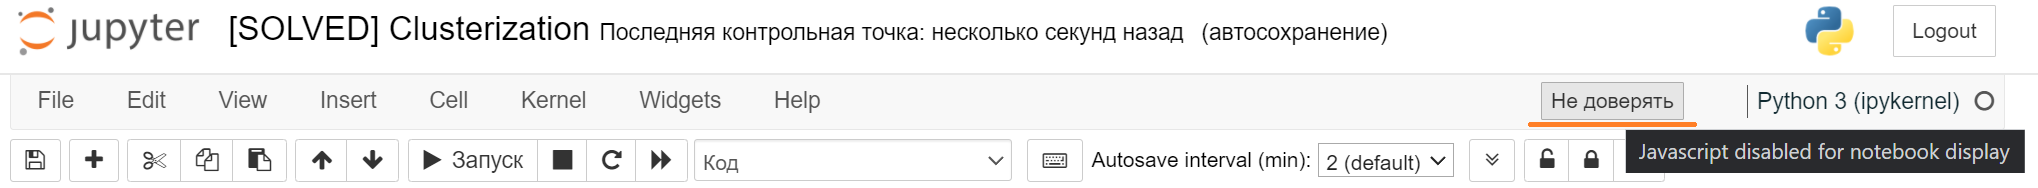

In [ ]:
import   sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install ray

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

import torch
import ray

В предыдущем задании мы тренировались в использовании фреймворка Pytorch, написании собственных модулей, реализации цикла обучения на игрушечном датасете с малым числом объектов довольно низкого разрешения. Сейчас же мы пойдём с другой стороны — будем использовать готовые реализации слоёв для нейронной сети и будем тестировать модели на данных умеренно большого размера и разрешения.

Так же как и в прошлом задании мы будем решать задачу многоклассовой классификации. При этом, вместо полносвязных сетей мы будем конструировать свёрточную сеть, которая за счёт своего inductive bias обычно работает лучше в задачах computer vision (CV).

В этот раз начнём с загрузки и предобработки данных для обучения. Pytorch реализует готовый набор классов и функций для работы с наборами данных. Обычно, при работе с **Pytorch** датасет представляют в виде наследника класса `torch.utils.data.Dataset`:
```python
class DatasetExample(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        
    def __getitem__(self, idx):
        '''
        Возвращает элемент датасета по его индексу
        :param int idx: Номер элемента в датасете
        :returns: Объект из выборки с порядковым номером idx
        '''
        ...
        
    def __len__(self):
        '''
        Опциональный метод, возвращает число элементов в датасете
        ...
```

Базовая работа с изображениями в **Pytorch** выделена в отдельный модуль `torchvision`. Эта библиотека позволяет:
* Загружать и работать с популярными датасетами компьютерного зрения
* Применять преобразования к изображениям в `PIL`, `numpy.ndarray` и `torch.Tensor` форматах
* Использовать специфичные для CV блоки и функции потерь
* Использовать готовые архитектуры CV моделей (включая предобученные модели)

Все датасеты в библиотеке `torchvision` наследуются от `torch.utils.data.Dataset`. Также, почти все датасеты имеют аргументы конструктора класса `transforms` и `target_transform`, которые определяют трансформации, применяемые ко входам сети (обычно к изображениям) и к таргетам (обычно к меткам классов) соответственно. Основные сценарии использования трансформаций включают в себя:
* Преобразование изображений из одного формата в другой. Например, обычно датасеты хранят и возвращают изображения в `PIL` формате, тогда как в нейросеть необходимо передавать изображения в виде `torch.Tensor`
* Нормализация и аугментация изображений
* Нормализация меток классов, то есть перевод их и строкового представления в численное

В библиотеке `torchvision` содержится большой набор [готовых трансформаций](https://pytorch.org/vision/stable/transforms.html).

Для работы с датасетом `CIFAR10` нам понадобится следующие из них:
* `torchvision.transforms.ToTensor` — преобразование `PIL` изображения в `torch.Tensor`
* `torchvision.transforms.Normalize` — нормализация изображения в формате `torch.Tensor`
* `torchvision.transforms.Compose` — класс, позволяющий объединять несколько последовательных трансформаций в одну

In [ ]:
import torchvision

In [ ]:
ray.util.connect('10.100.195.105:10001')

Загрузим датасет `CIFAR10` и посмотрим на его содержимое: 

In [ ]:
# Обратите внимание на аргументы функции: 
#   train отвечает за то, какой сплит нужно использовать, то есть обучающую или тестовую выборку
#   download отвечает за загрузку датасета из интернета
ds_train_no_transform = torchvision.datasets.CIFAR10(
    root='~/', train=True, transform=None, download=True
)

In [ ]:
print(f'Описание датасета:\n{ds_train_no_transform}\n')
print(f'Объект датасета — PIL изображение и метка: {ds_train_no_transform[0]}\n')

image, label = ds_train_no_transform[4]

plt.imshow(image)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Создадим `transform` для изображения, которое преобразует его из `PIL` формата в `torch.Tensor`, а затем нормализует:

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Используем среднее и стандартное отклонение, посчитанные для датасета CIFAR10
    # https://github.com/kuangliu/pytorch-cifar/issues/16
    torchvision.transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), 
        std=(0.2023, 0.1994, 0.2010)
    )
])

Применим трансформацию к изображению:

In [ ]:
image, label = ds_train_no_transform[6]
print(f'Тип изображения до трансформации: {type(image)}. Размер: {image.size}. Тип изображения: {image.mode}')

image_tensor = transform(image)
print(f'Тип изображения после трансформации: {type(image_tensor)}. Размер: {image_tensor.shape}')

plt.imshow(image)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Создайте датасеты с обучающим и тестовым сплитом датасета `CIFAR10`. Не забудьте передать функцию для трансформации.

In [ ]:
### your code here
ds_train = torchvision.datasets.CIFAR10(
    root='~/', train=True, transform=transform, download=False, 
)
ds_test = torchvision.datasets.CIFAR10(
    root='~/', train=False, transform=transform, download=False, 
)

In [ ]:
ds_train, ds_test,

Для удобства сразу же определим обратное преобразование, которое из тензора делает PIL изображение, которое можно корректно отобразить:

In [ ]:
tmean, tstd = transform.transforms[1].mean, transform.transforms[1].std
tmean, tstd = np.array(tmean), np.array(tstd)

inverse_transform = transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=-tmean / tstd, 
        std=1.0 / tstd
    ),
    torchvision.transforms.ToPILImage()
])

Посмотрим на несколько изображений из обучающей и тестовой выборок:

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, ds in enumerate((ds_train, ds_test)):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds), size=5)):
        image, label = ds[kdx]
        axes[idx, jdx].imshow(inverse_transform(image))
        axes[idx, jdx].set_title(f'Метка: {label} -> {ds.classes[label]}')


axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')
        
fig.tight_layout()
plt.show()

В прошлом задании мы использовали оптимизатор, который требовал подсчёта градиента по всей выборке. Однако, на практике обычно используют стохастические методы оптимизации, которые используют батчи объектов, семплированных из обучающей выборки. Хотя перемешивание и объединение в батчи объектов из датасета можно проводить вручную, **Pytorch** позволяет делать эти операции значительно более эффективно. Для этого обычно используют класс, который преобразует датасет в генератор батчей `torch.utils.data.DataLoader`. Данная обёртка позволяет объединять объекты в один батч, то есть объединять соответствующие тензоры в каждом объекте (например, изображения и соответствующие метки).

Основные параметры даталоадера:
- `batch_size` — размер подвыборки, семплируемый при каждом обращении к инстансту
- `shuffle` — перемешивать выборку или нет
- `num_workers` — ключевой параметр, который определяет производительность генератора батчей. Опишем влияние этого параметра подробнее. В процессе генерации очередного батча даталоадер должен выполнить несколько медленных процедур: запрос объектов из соответствующего датасета, что часто включает в себя чтение из жёсткого диска (так как большие датасеты не помещаются в оперативную память), применение трансформаций ко всем изображениям и конкатенация отдельных объектов в один тензор. Часто оказывается так, что вычисление прямого прохода по сети происходит быстрее, чем генерируется очередной батч, что приводит к существенно неэффективной программе. В таком случае, необходимо увеличить число параллельных процессов, каждый из которых генерирует очередной батч данных. На практике, выбор правильного числа воркеров может давать кратный прирост в скорости (обычно, перебор начинают с $3-4$ воркеров) 

Создайте даталоадеры для обучающей и тестовой выборок CIFAR10. Учтите, что обучающая выборка должна перемешиваться при каждом проходе по выборке, а тестовая выборка — нет.

In [ ]:
batch_size = 128

### your code here
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, num_workers=0)

Посмотрим на батч из даталоадера:

In [ ]:
images, labels = next(iter(dl_train))
print(images.shape, labels.shape)

Реализуем свёрточную VGG-подобную сеть. Сеть будет состоять из трёх основных блоков:
1. Свёрточный feature extractor
    * Эта последовательность слоёв принимает на вход изображение с $3$ каналами
    * Последовательность слоёв задаётся конфигурационным списком `cfg`:
        - Число означает количество выходных каналов очередной свёртки. Используйте свёртки с ядром $3\times3$ и паддингом $1$
        - `"M"` означает слой Max Pooling. Каждый такой слой должен уменьшать пространственные размерности картинки в $2$ раза
2. Слой Adaptive Average Pooling
    - Используйте выходное пространственное разрешение $2\times2$
3. Полносвязная "голова"-классификатор с $2$ скрытыми слоями размерности $128$

* В качестве функции активации везде используйте `ReLU`
* В зависимости от флага `use_batchnorm` добавьте батчнорм после каждого свёрточного слоя
* Между полносвязными слоям добавьте слои `Dropout` со значением $p = \text{dropout_p}$
* Используйте только готовые модули из `torch.nn`. Для объединения слоёв в блоки используйте `torch.nn.Sequential`

In [ ]:
class ConvNet(torch.nn.Module):
    cfg = [32, "M", 64, 64, "M", 128, 128, "M"]
    def __init__(self, n_classes=10, use_batchnorm=False, dropout_p=0.0):
        '''
        :param int n_classes: Число выходных признаков
        :param bool use_batchnorm: Использовать ли батчнорм между свёрточными слоями
        :param float dropout_p: Вероятность обнуления активации слоем Dropout
        '''
        super().__init__()
        layers = []
        in_channels = 3
        for v in self.cfg:
            if v == 'M':
                layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = torch.nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if use_batchnorm:
                    layers += [conv2d, torch.nn.BatchNorm2d(v), torch.nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, torch.nn.ReLU(inplace=True)]
                in_channels = v
        self.features = torch.nn.Sequential(*layers)
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(2,2))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=2 * 2 * in_channels, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(p=dropout_p),
            torch.nn.Linear(in_features=128, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(p=dropout_p),
            torch.nn.Linear(in_features=128, out_features=n_classes)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### your code here
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return(x)

В качестве функции потерь будем использовать, так же как и в прошлом задании, кроссэнтропию, но в этот раз её готовую реализацию. В качестве оптимизатора возьмём базовый оптимизатор в машинном обучении — SGD:

In [ ]:
conv_network = ConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

Определим устройство для вычислений и перенесём модель:

In [ ]:
device = torch.device('cuda', 0)

In [ ]:
# conv_network.to.remote(device)

Теперь осталось реализовать цикл обучения для нейронной сети. Так как в данном задании будет использоваться оптимизатор SGD, то необходимость в реализации шага оптимизации через функцию-замыкание отсутствует. Реализуйте шаг оптимизации любым удобным способом.

In [ ]:

@ray.remote(num_gpus=1)
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test, device):
    network.to(device)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    pbar = range(n_epochs)
    for epoch in pbar:
        network.train()
        for images, labels in dl_train:
            #print('qq')
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = network(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            network.eval()
            with torch.no_grad():
                loss = 0.0
                accuracy = 0.0
                count = 0
                for images, labels in dl_train:
                    #print('qqq')
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = network(images)
                    count += labels.shape[0]
                    loss += loss_fn(outputs, labels).detach() * labels.shape[0]
                    accuracy += torch.sum(torch.argmax(outputs, axis=1) == labels).detach()
                train_losses.append(loss / count)
                train_accuracies.append(accuracy / count)
                loss = 0.0
                accuracy = 0.0
                count = 0
                for images, labels in dl_test:
                    #print('qqqq')
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = network(images)
                    count += labels.shape[0]
                    loss += loss_fn(outputs, labels).detach() * labels.shape[0]
                    accuracy += torch.sum(torch.argmax(outputs, axis=1) == labels).detach()
                test_losses.append(loss / count)
                test_accuracies.append(accuracy / count)
    return list(map(lambda x: x.cpu(), train_losses)), list(map(lambda x: x.cpu(), test_losses)), list(map(lambda x: x.cpu(), train_accuracies)), list(map(lambda x: x.cpu(), test_accuracies))

Наконец, всё готово к обучению модели:

In [ ]:
n_epochs = 5

task1 = training_loop.remote(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn, 
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

lst = [task1]
while True:
    sp = ray.wait(lst, num_returns=1, timeout=20)
    if sp[1] == []:
        break
    elif sp[0] != [] and sp[1] != []:
        lst = lst[1:]
    else:
        print('waiting')

train_losses, test_losses, train_accs, test_accs = ray.get(task1)
ray.cancel(task1)
ray.util.disconnect()
ray.util.connect('10.100.195.105:10001')

**Задание 1.** Посторим график качества на обучении и на тесте: 

**Задание 2.** Теперь, для сравнения обучите модели с батчнормом, дропаутом (используйте $p=0.5$) и с тем и с другим. Не забудьте сохранить все метрики, чтобы затем сравнить на графике все $4$ рассмотренные модели:

In [ ]:
### your code here

conv_network = ConvNet(dropout_p=0.5)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

task2 = training_loop.remote(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn, 
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

lst = [task2]
while True:
    sp = ray.wait(lst, num_returns=1, timeout=20)
    if sp[1] == []:
        break
    elif sp[0] != []:
        lst = lst[1:]
    else:
        print('waiting')

train_losses_dp, test_losses_dp, train_accs_dp, test_accs_dp = ray.get(task2)
ray.cancel(task2)
ray.util.disconnect()
ray.util.connect('10.100.195.105:10001')

In [ ]:
conv_network = ConvNet(use_batchnorm=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

task3 = training_loop.remote(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn, 
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

lst = [task3]
while True:
    sp = ray.wait(lst, num_returns=1, timeout=20)
    if sp[1] == []:
        break
    elif sp[0] != [] and sp[1] != []:
        lst = lst[1:]
    else:
        print('waiting')

train_losses_bn, test_losses_bn, train_accs_bn, test_accs_bn = ray.get(task3)
ray.cancel(task3)
ray.util.disconnect()
ray.util.connect('10.100.195.105:10001')

In [ ]:
conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

task4 = training_loop.remote(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn, 
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

lst = [task4]
while True:
    sp = ray.wait(lst, num_returns=1, timeout=20)
    if sp[1] == []:
        break
    elif sp[0] != [] and sp[1] != []:
        lst = lst[1:]
    else:
        print('waiting')

train_losses_bn_dp, test_losses_bn_dp, train_accs_bn_dp, test_accs_bn_dp = ray.get(task4)
ray.cancel(task4)
ray.util.disconnect()
ray.util.connect('10.100.195.105:10001')